This Notebook will go over Feature extraction , some Visualization and Modeling
lets start with imports and loading the main class Molecules that works on a directory with feather files,
we will use the example in the package.
Change ROOT_DIR accordingly.


In [159]:
%reset -f
%reload_ext autoreload
%autoreload 2

import os
import sys
import importlib
import numpy as np
import pandas as pd

# === Setup ===
ROOT_DIR = r'C:\Users\edens\Documents\GitHub\LabCode\MolFeatures'
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'M3_modeler'))
sys.path.append(os.path.join(ROOT_DIR, 'M2_data_extractor'))
sys.path.append(os.path.join(ROOT_DIR, 'utils'))

os.chdir(ROOT_DIR)  # Set working directory

# === Clear old module caches ===
for module in ['data_extractor', 'feather_extractor', 'gaussian_handler', 'help_functions', 'modeling', 'plot']:
    sys.modules.pop(module, None)

# === Safe Imports ===
try:
    from data_extractor import Molecules, extract_connectivity
    from feather_extractor import logs_to_feather
    import gaussian_handler
    from gaussian_handler import feather_file_handler
    from help_functions import dict_to_horizontal_df, get_df_from_file
    import help_functions
    import visualize
    from modeling import (
        ClassificationModel,
        LinearRegressionModel,
        fit_and_evaluate_single_combination_regression,
        fit_and_evaluate_single_combination_classification
    )
    import plot
except ModuleNotFoundError as e:
    print(f"Module import failed: {e}")

# === Config ===
pd.set_option('display.max_columns', None)

# === Load molecular data ===
feather_path = r'C:\Users\edens\Documents\GitHub\lucas_project\new_feather_substrate\set1'
mols = Molecules(feather_path)


Molecules Loaded: ['LS1621.feather', 'LS1630.feather', 'LS1641.feather', 'LS1642.feather', 'LS1643.feather', 'LS1687.feather', 'LS1688.feather', 'LS1690.feather', 'LS1695.feather', 'LS1714.feather', 'LS1715.feather', 'LS1717.feather', 'LS1726.feather', 'LS2002.feather', 'LS2003.feather', 'LS2005.feather', 'LS2007.feather'] Failed Molecules: []


Great we can see the files Loaded ! 
lets print the methods for the mols object we created to see what wee can use.

In [2]:
methods=[method for method in dir(mols) if not method.startswith('_')]
print(methods)

['export_all_xyz', 'extract_all_dfs', 'extract_all_xyz', 'failed_molecules', 'filter_molecules', 'get_bend_vibration_dict', 'get_bond_angle_dict', 'get_bond_length_dict', 'get_charge_df_dict', 'get_charge_diff_df_dict', 'get_dipole_dict', 'get_molecules_comp_set_app', 'get_npa_dict', 'get_ring_vibration_dict', 'get_sterimol_dict', 'get_stretch_vibration_dict', 'molecules', 'molecules_names', 'molecules_path', 'old_molecules', 'old_molecules_names', 'success_molecules', 'visualize_molecules', 'visualize_smallest_molecule', 'visualize_smallest_molecule_morfeus']


In [133]:
for mol in mols.molecules:
    # replace nan in atoms with Pd not NaN
    mol.xyz_df['atom'] = mol.xyz_df['atom'].replace('nan', 'Pd')

Great now lets use visualize_molecules to see the first molecule of the set.


In [119]:
mols.visualize_molecules([0,1])

🔥 atoms: ['C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'N', 'Pd', 'H', 'H', 'H', 'H', 'H', 'C', 'H', 'C', 'C', 'H', 'H', 'H', 'H', 'C', 'H', 'H', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'C', 'F', 'F', 'F', 'N', 'C', 'C', 'C', 'C', 'H', 'C', 'H', 'C', 'H', 'H', 'O', 'C', 'H', 'H', 'H']
🔥 dipole vector: array([-1.0427, -2.1032, -2.0568]) (scaled by 5)


🔥 atoms: ['C', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'C', 'N', 'Pd', 'H', 'H', 'H', 'H', 'H', 'H', 'C', 'H', 'C', 'C', 'H', 'H', 'H', 'H', 'C', 'H', 'H', 'H', 'C', 'H', 'C', 'H', 'H', 'H', 'H', 'H', 'O', 'C', 'H', 'H', 'H', 'N', 'C', 'C', 'C', 'C', 'H', 'C', 'H', 'C', 'H', 'C', 'C', 'F', 'F', 'F', 'F', 'F', 'F']
🔥 dipole vector: array([-9.6109,  3.9002,  1.8389]) (scaled by 5)


Now that we see the molecules and atom numbering we can extract features. Remember it need to be numbered the same across the set !

In [ ]:
answers_dict = {
    "Ring Vibration atoms - by order -> Pick primary atom and para to it: \n example: 13,17": [9, 8],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [],
    "Bend Threshold": [3000],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [16, 17],
    "Center_Atoms Dipole": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[11, 6, 4], [10, 11, 12], [11, 12, 5], [4, 5, 1], [4, 3, 2],[1,2,3]],
    "Sub-Atoms NPA": [1, 3, 5, 11, 8, 12, 14, 4, 6] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [[11, 6, 4], [10, 11, 12], [11, 12, 5], [4, 5, 1], [4, 3, 2]],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [3,5,11,12,4,6,20,21,22,7],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [[3, 5], [5, 12], [11, 5], [3, 11]],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[4,6], [6, 4]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [12,20,21,22,23,24,25,26],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[11, 6], [6, 4], [1, 5], [11, 6],[21,22]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[11, 6, 4], [6, 4, 5], [1, 5, 4], [11, 6, 4]],
}
df=mols.get_molecules_comp_set_app(entry_widgets=answers_dict,answers_list=None)

In [150]:
answers_dict = {
    "Ring Vibration atoms - by order -> Pick primary atom and para to it: \n example: 13,17": [9, 8],
    "Stretch Threshold": [1600],
    "Stretching Vibration atoms- enter bonded atom pairs: \n example: 1,2 4,5": [],
    "Bend Threshold": [3000],
    "Bending Vibration atoms - enter atom pairs that have a common atom: \n example: 4,7": [15, 16],
    "Center_Atoms Dipole": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
    "Dipole atoms - indices for coordination transformation: \n example: 4,5,6 - origin, y-axis, new xy plane": [[10, 5, 3], [9, 10, 11], [10, 11, 4], [3, 4, 1], [3, 43, 2],[1,2,43]],
    "Sub-Atoms NPA": [1, 3, 5, 11, 8, 12, 14, 4, 6] ,
    "NPA manipulation atoms - Insert atoms to show NPA: \n example: 1,2,4": [[11, 6, 4], [10, 11, 12], [11, 12, 5], [4, 5, 1], [4, 3, 2]],
    "charges values - Insert atoms to show charge: \n example: 1,2,3,4": [43,4,10,11,3,5,19,20,21,6],
    "charge_diff - Insert atoms to show charge difference: \n example: 1,2 3,4": [[43, 4], [10, 4], [43, 10]],
    "Sterimol atoms - Primary axis along: \n example: 7,8": [[3,5], [5, 3]],
    'drop_atoms - Atoms to drop: \n example: 1,2,3': [11,19,20,21,22,23,24,25],
    "Bond_length - Atom pairs to calculate difference: \n example: 1,2 4,5": [[10, 5], [5, 3], [1, 4], [10, 5],[20,21]],
    'Bond_angle - Atom triplets to calculate difference: \n example: 1,2,3 4,5,6': [[10, 5, 3], [5, 3, 4], [1, 4, 3], [10, 5, 3]],
}
df=mols.get_molecules_comp_set_app(entry_widgets=answers_dict,answers_list=None)

In [151]:
metal_vib = dict_to_horizontal_df(mols.get_stretch_vibration_dict([11,19], 2300))

Calculating stretch vibration for atoms [11, 19] with threshold 2300 
 Remember : ALWAYS LOOK AT THE RESULTING VIBRATION


In [152]:
df = pd.concat([df, metal_vib], axis=1)
df.head()

,cross,cross_angle,para,para_angle,Frequency_Bending_15-16,Cross_mag_Bending_15-16,dip_x_NPA_11-6-4,dip_y_NPA_11-6-4,dip_z_NPA_11-6-4,total_dipole_NPA_11-6-4,dip_x_NPA_10-11-12,dip_y_NPA_10-11-12,dip_z_NPA_10-11-12,total_dipole_NPA_10-11-12,dip_x_NPA_11-12-5,dip_y_NPA_11-12-5,dip_z_NPA_11-12-5,total_dipole_NPA_11-12-5,dip_x_NPA_4-5-1,dip_y_NPA_4-5-1,dip_z_NPA_4-5-1,total_dipole_NPA_4-5-1,dip_x_NPA_4-3-2,dip_y_NPA_4-3-2,dip_z_NPA_4-3-2,total_dipole_NPA_4-3-2,dipole_x_10-5-3,dipole_y_10-5-3,dipole_z_10-5-3,total_dipole_10-5-3,dipole_x_9-10-11,dipole_y_9-10-11,dipole_z_9-10-11,total_dipole_9-10-11,dipole_x_10-11-4,dipole_y_10-11-4,dipole_z_10-11-4,total_dipole_10-11-4,dipole_x_3-4-1,dipole_y_3-4-1,dipole_z_3-4-1,total_dipole_3-4-1,dipole_x_3-43-2,dipole_y_3-43-2,dipole_z_3-43-2,total_dipole_3-43-2,dipole_x_1-2-43,dipole_y_1-2-43,dipole_z_1-2-43,total_dipole_1-2-43,nbo_atom_43,nbo_atom_4,nbo_atom_10,nbo_atom_11,nbo_atom_3,nbo_atom_5,nbo_atom_19,nbo_atom_20,nbo_atom_21,nbo_atom_6,hirshfeld_atom_43,hirshfeld_atom_4,hirshfeld_atom_10,hirshfeld_atom_11,hirshfeld_atom_3,hirshfeld_atom_5,hirshfeld_atom_19,hirshfeld_atom_20,hirshfeld_atom_21,hirshfeld_atom_6,cm5_atom_43,cm5_atom_4,cm5_atom_10,cm5_atom_11,cm5_atom_3,cm5_atom_5,cm5_atom_19,cm5_atom_20,cm5_atom_21,cm5_atom_6,nbo_diff_43-4,nbo_diff_10-4,nbo_diff_43-10,hirshfeld_diff_43-4,hirshfeld_diff_10-4,hirshfeld_diff_43-10,cm5_diff_43-4,cm5_diff_10-4,cm5_diff_43-10,B1_3-5,B5_3-5,L_3-5,loc_B5_3-5,B1_B5_angle_3-5,B1_5-3,B5_5-3,L_5-3,loc_B5_5-3,B1_B5_angle_5-3,"angle_[10, 5, 3]","angle_[5, 3, 4]","angle_[1, 4, 3]",bond_length_10-5,bond_length_5-3,bond_length_1-4,bond_length_20-21,aniso,iso,energy,Frequency_Stretch_11_19,Amplitude_Stretch_11_19
LS1689,1637.648,1.397978,1686.0636,71.504135,3166.7862,0.281607,0.829224,-0.014957,0.486175,0.961354,0.612603,0.58099,-0.145328,0.85671,-0.737507,0.159862,0.263154,0.799201,0.701847,-1.005224,0.485646,1.31868,1.133618,-0.697296,0.204652,1.346549,-0.931673,-9.393739,4.674629,10.5339,8.946262,-5.258283,1.81035,10.5339,-9.421643,3.698677,-2.91804,10.5339,-8.701504,5.385239,-2.499107,10.5339,1.895113,-9.847648,3.224109,10.5339,2.863874,-8.040339,-6.173628,10.5339,-0.41163,-0.4788,-0.46739,0.31138,0.47212,0.13765,0.11011,-0.37479,-0.37697,-0.23526,-0.034927,-0.103828,-0.108047,0.218036,0.122968,0.049688,-0.000232,-0.029787,-0.029917,-0.035053,-0.28293,-0.369728,-0.351794,0.423285,0.275326,0.123732,0.013906,-0.164733,-0.165095,-0.075576,0.06717,0.01141,0.05576,0.068901,-0.004219,0.07312,0.086798,0.017934,0.068864,1.9858,6.2826,6.2804,-0.8009,118.1269,2.1006,7.7798,7.1826,0.1518,144.7414,114.198374,120.407497,109.024919,1.349137,1.488932,1.478116,1.362695,320.818,229.296,6.306786,2313.0354,1.500178


Database already exists at: results_new_features_set_combined.db
Table 'regression_results' has been ensured to exist.
linear model selected

--- Correlation Report ---
Features with correlation above 0.8:
['energy', 'dipole_y_1-2-3', 'para_angle', 'hirshfeld_diff_5-12', 'total_dipole_4-3-2', 'hirshfeld_atom_21', 'L_6-4', 'bond_length_6-4', 'nbo_diff_3-11', 'nbo_atom_7', 'dipole_z_10-11-12', 'hirshfeld_atom_7', 'total_dipole_11-12-5', 'nbo_atom_3', 'hirshfeld_atom_11', 'nbo_diff_5-12', 'total_dipole_1-2-3', 'dipole_y_11-12-5', 'B5_6-4', 'aniso', 'nbo_atom_12', 'Cross_mag_Bending_17-18', 'dipole_x_11-12-5', 'dipole_y_4-5-1', 'dipole_x_4-5-1', 'angle_[1, 5, 4]', 'nbo_atom_11', 'dipole_z_11-12-5', 'dipole_z_1-2-3', 'nbo_atom_4', 'dipole_x_1-2-3', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'dipole_z_4-3-2', 'dipole_x_11-6-4', 'angle_[6, 4, 5]', 'hirshfeld_atom_5', 'dipole_y_4-3-2', 'hirshfeld_diff_3-11', 'nbo_atom_21', 'dipole_z_11-6-4', 'dipole_x_10-11-12', 'hirshfeld_diff_3-5', 'dipole_y_

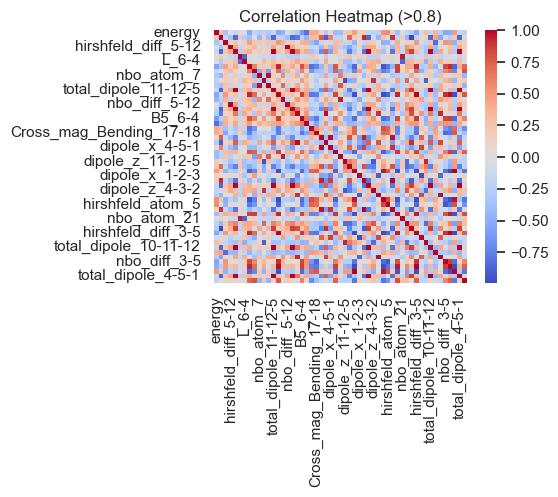


Correlated features were not dropped.

Using 1 jobs for evaluation. Found 20 cores.
Combos to run: 1423590, done_combos: 2836
Evaluating 1423590 new combos with R2 >= 0.7...


Threshold 0.7 (single-core):   0%|          | 3326/1423590 [00:18<1:56:35, 203.03it/s]

Error evaluating combo ('cross', 'para', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   0%|          | 3569/1423590 [00:19<1:57:58, 200.62it/s]

Error evaluating combo ('cross', 'para', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   0%|          | 3833/1423590 [00:21<1:56:25, 203.23it/s]

Error evaluating combo ('cross', 'para', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   0%|          | 4070/1423590 [00:22<1:57:47, 200.86it/s]

Error evaluating combo ('cross', 'para', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'para', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   0%|          | 4287/1423590 [00:23<2:01:14, 195.11it/s]

Error evaluating combo ('cross', 'para', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   0%|          | 4565/1423590 [00:25<2:11:06, 180.39it/s]

Data normalized. Variance: 0.9999999999999999
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.337, % Error = 610.86%
Index 1: Actual = 0.265, Predicted = 0.292, % Error = 10.10%
Index 2: Actual = 0.000, Predicted = 0.236, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.632, % Error = -13.29%
Index 4: Actual = 1.882, Predicted = 1.878, % Error = -0.19%
Index 5: Actual = 2.304, Predicted = 2.054, % Error = -10.89%
Index 6: Actual = 2.304, Predicted = 1.464, % Error = -36.48%
Index 7: Actual = 1.743, Predicted = 1.698, % Error = -2.60%
Index 8: Actual = 1.532, Predicted = 1.258, % Error = -17.86%
Index 9: Actual = 1.370, Predicted = 1.441, % Error = 5.18%
Index 10: Actual = 1.532, Predicted = 1.282, % Error = -16.31%
Index 11: Actual = 1.629, Predicted = 1.647, % Error = 1.08%
Index 12: Actual = 1.027, Predicted = 1.752, % Error = 70.54%
Index 13: Actual = 0.000, Predicted = -0.249, % Error = nan%
Index 14: Actual = 0.071, 

Threshold 0.7 (single-core):   0%|          | 4734/1423590 [00:26<2:20:03, 168.84it/s]

Data normalized. Variance: 1.0
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.444, % Error = 835.98%
Index 1: Actual = 0.265, Predicted = 0.171, % Error = -35.32%
Index 2: Actual = 0.000, Predicted = 0.431, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.200, % Error = -36.25%
Index 4: Actual = 1.882, Predicted = 2.038, % Error = 8.30%
Index 5: Actual = 2.304, Predicted = 2.250, % Error = -2.35%
Index 6: Actual = 2.304, Predicted = 1.466, % Error = -36.37%
Index 7: Actual = 1.743, Predicted = 1.397, % Error = -19.90%
Index 8: Actual = 1.532, Predicted = 1.229, % Error = -19.78%
Index 9: Actual = 1.370, Predicted = 1.271, % Error = -7.22%
Index 10: Actual = 1.532, Predicted = 1.758, % Error = 14.80%
Index 11: Actual = 1.629, Predicted = 1.546, % Error = -5.13%
Index 12: Actual = 1.027, Predicted = 1.634, % Error = 59.07%
Index 13: Actual = 0.000, Predicted = -0.128, % Error = nan%
Index 14: Actual = 0.071, Predicted = 0.

Threshold 0.7 (single-core):   0%|          | 4977/1423590 [00:27<2:41:34, 146.34it/s]

Data normalized. Variance: 1.0
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.362, % Error = 664.55%
Index 1: Actual = 0.265, Predicted = 0.231, % Error = -12.64%
Index 2: Actual = 0.000, Predicted = 0.369, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.545, % Error = -17.89%
Index 4: Actual = 1.882, Predicted = 1.913, % Error = 1.67%
Index 5: Actual = 2.304, Predicted = 2.043, % Error = -11.34%
Index 6: Actual = 2.304, Predicted = 1.478, % Error = -35.87%
Index 7: Actual = 1.743, Predicted = 1.402, % Error = -19.57%
Index 8: Actual = 1.532, Predicted = 1.331, % Error = -13.11%
Index 9: Actual = 1.370, Predicted = 1.331, % Error = -2.84%
Index 10: Actual = 1.532, Predicted = 1.777, % Error = 16.01%
Index 11: Actual = 1.629, Predicted = 1.569, % Error = -3.73%
Index 12: Actual = 1.027, Predicted = 1.597, % Error = 55.48%
Index 13: Actual = 0.000, Predicted = -0.359, % Error = nan%
Index 14: Actual = 0.071, Predicted = -

Threshold 0.7 (single-core):   0%|          | 5116/1423590 [00:28<2:22:31, 165.88it/s]

Data normalized. Variance: 1.0
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.440, % Error = 828.60%
Index 1: Actual = 0.265, Predicted = 0.158, % Error = -40.52%
Index 2: Actual = 0.000, Predicted = 0.425, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.259, % Error = -33.12%
Index 4: Actual = 1.882, Predicted = 2.037, % Error = 8.22%
Index 5: Actual = 2.304, Predicted = 2.219, % Error = -3.69%
Index 6: Actual = 2.304, Predicted = 1.470, % Error = -36.22%
Index 7: Actual = 1.743, Predicted = 1.441, % Error = -17.38%
Index 8: Actual = 1.532, Predicted = 1.286, % Error = -16.04%
Index 9: Actual = 1.370, Predicted = 1.335, % Error = -2.59%
Index 10: Actual = 1.532, Predicted = 1.650, % Error = 7.73%
Index 11: Actual = 1.629, Predicted = 1.555, % Error = -4.53%
Index 12: Actual = 1.027, Predicted = 1.698, % Error = 65.31%
Index 13: Actual = 0.000, Predicted = -0.217, % Error = nan%
Index 14: Actual = 0.071, Predicted = 0.1

Threshold 0.7 (single-core):   0%|          | 5375/1423590 [00:30<2:07:58, 184.69it/s]

Data normalized. Variance: 0.9999999999999999
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.366, % Error = 673.25%
Index 1: Actual = 0.265, Predicted = 0.226, % Error = -14.86%
Index 2: Actual = 0.000, Predicted = 0.348, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.569, % Error = -16.63%
Index 4: Actual = 1.882, Predicted = 1.936, % Error = 2.88%
Index 5: Actual = 2.304, Predicted = 2.033, % Error = -11.80%
Index 6: Actual = 2.304, Predicted = 1.494, % Error = -35.18%
Index 7: Actual = 1.743, Predicted = 1.496, % Error = -14.21%
Index 8: Actual = 1.532, Predicted = 1.418, % Error = -7.42%
Index 9: Actual = 1.370, Predicted = 1.402, % Error = 2.36%
Index 10: Actual = 1.532, Predicted = 1.528, % Error = -0.24%
Index 11: Actual = 1.629, Predicted = 1.618, % Error = -0.72%
Index 12: Actual = 1.027, Predicted = 1.688, % Error = 64.37%
Index 13: Actual = 0.000, Predicted = -0.367, % Error = nan%
Index 14: Actual = 0.071, 

Threshold 0.7 (single-core):   0%|          | 5411/1423590 [00:30<2:33:04, 154.41it/s]

Data normalized. Variance: 1.0
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = 0.047, Predicted = 0.287, % Error = 505.83%
Index 1: Actual = 0.265, Predicted = 0.127, % Error = -52.18%
Index 2: Actual = 0.000, Predicted = 0.380, % Error = nan%
Index 3: Actual = 1.882, Predicted = 1.633, % Error = -13.23%
Index 4: Actual = 1.882, Predicted = 1.731, % Error = -8.03%
Index 5: Actual = 2.304, Predicted = 2.047, % Error = -11.16%
Index 6: Actual = 2.304, Predicted = 1.712, % Error = -25.72%
Index 7: Actual = 1.743, Predicted = 1.344, % Error = -22.89%
Index 8: Actual = 1.532, Predicted = 1.415, % Error = -7.60%
Index 9: Actual = 1.370, Predicted = 1.433, % Error = 4.63%
Index 10: Actual = 1.532, Predicted = 1.682, % Error = 9.85%
Index 11: Actual = 1.629, Predicted = 1.446, % Error = -11.27%
Index 12: Actual = 1.027, Predicted = 1.431, % Error = 39.31%
Index 13: Actual = 0.000, Predicted = -0.147, % Error = nan%
Index 14: Actual = 0.071, Predicted = 0.

Threshold 0.7 (single-core):   1%|          | 8653/1423590 [00:50<2:01:41, 193.80it/s]

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 8820/1423590 [00:52<3:41:46, 106.32it/s]

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_y_10-11-12', 'bond_length_22-23'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_y_10-11-12', 'Frequency_Stretch_12_21'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_z_10-11-12', 'dipole_y_11-12-5'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_z_10-11-12', 'dipole_z_11-12-5'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_z_10-11-12', 'total_dipole_11-12-5'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'dipole_z_10-11-12', 'dipole_x_4-5-1'): [Errno 13] Permission denied

Threshold 0.7 (single-core):   1%|          | 8894/1423590 [00:52<4:09:40, 94.44it/s] 

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 9141/1423590 [00:55<3:25:30, 114.71it/s]

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 9371/1423590 [00:57<2:45:09, 142.71it/s]

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 9608/1423590 [00:59<2:23:06, 164.67it/s]

Error evaluating combo ('cross', 'Frequency_Bending_17-18', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 11194/1423590 [01:10<2:37:07, 149.81it/s]

Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 11451/1423590 [01:12<2:41:44, 145.51it/s]

Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 11708/1423590 [01:14<2:27:14, 159.82it/s]

Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 11942/1423590 [01:15<2:27:08, 159.89it/s]

Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 12145/1423590 [01:18<3:47:53, 103.23it/s]

Error evaluating combo ('cross', 'Cross_mag_Bending_17-18', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 13666/1423590 [01:28<2:54:24, 134.74it/s]

Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 13935/1423590 [01:30<2:03:40, 189.97it/s]

Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 14205/1423590 [01:31<1:58:56, 197.48it/s]

Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 14423/1423590 [01:33<2:01:42, 192.97it/s]

Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 14651/1423590 [01:34<2:04:08, 189.17it/s]

Error evaluating combo ('cross', 'dipole_x_11-6-4', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 16081/1423590 [01:43<2:29:10, 157.26it/s]

Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 16340/1423590 [01:45<4:11:39, 93.20it/s] 

Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 16594/1423590 [01:47<3:41:01, 106.09it/s]

Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 16823/1423590 [01:50<3:18:29, 118.12it/s]

Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|          | 17040/1423590 [01:51<3:23:13, 115.35it/s]

Error evaluating combo ('cross', 'dipole_y_11-6-4', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 18431/1423590 [02:03<3:23:06, 115.31it/s]

Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-6-4', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-6-4', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-6-4', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-6-4', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 18693/1423590 [02:06<3:36:45, 108.02it/s]

Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 18936/1423590 [02:08<3:42:19, 105.30it/s]

Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 19174/1423590 [02:10<2:57:26, 131.92it/s]

Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 19391/1423590 [02:12<3:34:17, 109.22it/s]

Error evaluating combo ('cross', 'dipole_z_11-6-4', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 20775/1423590 [02:23<2:20:36, 166.29it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_x_10-11-12', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_x_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_x_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_x_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_x_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 20823/1423590 [02:23<2:51:47, 136.09it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_10-11-12', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 20892/1423590 [02:24<3:28:04, 112.35it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_10-11-12', 'total_dipole_10-11-12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 21025/1423590 [02:25<1:34:32, 247.28it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_x_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_y_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_z_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_x_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_y_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'dipole_z_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 

Threshold 0.7 (single-core):   1%|▏         | 21089/1423590 [02:25<2:54:24, 134.02it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_11-12-5', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 21153/1423590 [02:26<2:51:49, 136.04it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_11-12-5', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   1%|▏         | 21263/1423590 [02:26<1:34:24, 247.56it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_x_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_y_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_z_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_x_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_y_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'dipole_z_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_11

Threshold 0.7 (single-core):   1%|▏         | 21331/1423590 [02:27<2:30:39, 155.13it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21397/1423590 [02:28<2:56:25, 132.46it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21490/1423590 [02:28<1:31:46, 254.64it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_x_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_y_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_z_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-5-1', 'nbo_atom_

Threshold 0.7 (single-core):   2%|▏         | 21561/1423590 [02:28<2:21:42, 164.89it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21614/1423590 [02:29<2:46:51, 140.04it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21704/1423590 [02:29<1:34:31, 247.18it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_4-3-2', 'nbo_atom_4'): Singular matr

Threshold 0.7 (single-core):   2%|▏         | 21773/1423590 [02:30<2:17:49, 169.51it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_y_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21829/1423590 [02:30<2:22:16, 164.21it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'dipole_z_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 21911/1423590 [02:30<1:20:47, 289.14it/s]

Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_4'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_6'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_20'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_21'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-6-4', 'total_dipole_1-2-3', 'nbo_atom_22'): Singular matrix
Error evaluati

Threshold 0.7 (single-core):   2%|▏         | 25326/1423590 [02:54<2:12:08, 176.36it/s]

Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_10-11-12', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_10-11-12', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_10-11-12', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_10-11-12', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 25569/1423590 [02:56<3:15:24, 119.24it/s]

Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 25798/1423590 [02:58<3:10:39, 122.19it/s]

Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 26020/1423590 [03:00<3:38:26, 106.64it/s]

Error evaluating combo ('cross', 'dipole_y_10-11-12', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29413/1423590 [03:31<4:13:52, 91.53it/s] 

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_x_11-12-5', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_x_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_x_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_x_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29479/1423590 [03:32<3:48:05, 101.87it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_11-12-5', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29541/1423590 [03:32<3:14:13, 119.62it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_11-12-5', 'total_dipole_11-12-5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29646/1423590 [03:33<1:35:45, 242.63it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_x_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_y_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_z_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_x_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_y_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'dipole_z_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12'

Threshold 0.7 (single-core):   2%|▏         | 29718/1423590 [03:33<2:15:17, 171.72it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29790/1423590 [03:34<2:35:15, 149.63it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29873/1423590 [03:34<1:23:15, 278.98it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_x_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_y_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_z_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_

Threshold 0.7 (single-core):   2%|▏         | 29954/1423590 [03:35<1:49:37, 211.87it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 29999/1423590 [03:35<1:55:03, 201.86it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 30120/1423590 [03:35<1:32:07, 252.10it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_4-3-2', 'nbo_atom_

Threshold 0.7 (single-core):   2%|▏         | 30149/1423590 [03:35<1:50:48, 209.59it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_y_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 30214/1423590 [03:36<2:28:26, 156.45it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'dipole_z_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 30295/1423590 [03:36<1:26:54, 267.19it/s]

Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_4'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_6'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_20'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_21'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_10-11-12', 'total_dipole_1-2-3', 'nbo_atom_22'): Singular mat

Threshold 0.7 (single-core):   2%|▏         | 31572/1423590 [03:44<2:16:30, 169.96it/s]

Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 31794/1423590 [03:45<2:14:24, 172.58it/s]

Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 32012/1423590 [03:46<2:05:13, 185.20it/s]

Error evaluating combo ('cross', 'dipole_x_11-12-5', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 33009/1423590 [03:53<2:01:26, 190.84it/s]

Error evaluating combo ('cross', 'dipole_x_11-12-5', 'hirshfeld_atom_7', 'Amplitude_Stretch_12_21'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'


Threshold 0.7 (single-core):   2%|▏         | 33457/1423590 [03:55<2:38:15, 146.39it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 33691/1423590 [03:57<2:33:04, 151.32it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 33756/1423590 [03:57<2:32:45, 151.63it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'nbo_atom_11'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'nbo_atom_21'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'nbo_atom_22'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'hirshfeld_atom_11'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'hirshfeld_atom_12'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'hirshfeld_atom_4'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_

Threshold 0.7 (single-core):   2%|▏         | 33774/1423590 [03:57<2:25:42, 158.97it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'bond_length_6-4'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'bond_length_1-5'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'bond_length_22-23'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'aniso'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'iso'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_4-3-2', 'energy'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'
Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_x_

Threshold 0.7 (single-core):   2%|▏         | 33806/1423590 [03:58<3:06:11, 124.41it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'dipole_y_4-3-2', 'hirshfeld_atom_3'): [Errno 13] Permission denied: 'results_new_features_set_combined.csv'


Threshold 0.7 (single-core):   2%|▏         | 33919/1423590 [03:58<2:21:58, 163.14it/s]

Error evaluating combo ('cross', 'dipole_y_11-12-5', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 35285/1423590 [04:07<2:11:05, 176.51it/s]

Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_11-12-5', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_11-12-5', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   2%|▏         | 35528/1423590 [04:08<2:11:20, 176.14it/s]

Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 35740/1423590 [04:10<2:24:54, 159.62it/s]

Error evaluating combo ('cross', 'dipole_z_11-12-5', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37109/1423590 [04:18<1:57:43, 196.29it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_x_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_x_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_x_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37169/1423590 [04:18<2:06:54, 182.07it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37223/1423590 [04:18<2:22:48, 161.79it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_4-5-1', 'total_dipole_4-5-1'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37331/1423590 [04:19<1:17:04, 299.73it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_x_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_y_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_z_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-5-1', '

Threshold 0.7 (single-core):   3%|▎         | 37393/1423590 [04:19<1:36:51, 238.53it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37443/1423590 [04:19<1:47:51, 214.19it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_4-3-2', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37563/1423590 [04:20<1:34:36, 244.18it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'dipole_x_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'dipole_y_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'dipole_z_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_4-3-2', 'nbo_atom_4'): Sing

Threshold 0.7 (single-core):   3%|▎         | 37617/1423590 [04:20<1:44:02, 222.01it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_y_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37664/1423590 [04:20<1:53:25, 203.66it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'dipole_z_1-2-3', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 37762/1423590 [04:21<1:28:16, 261.64it/s]

Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_3'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_5'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_11'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_12'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_4'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_6'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_20'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_21'): Singular matrix
Error evaluating combo ('cross', 'total_dipole_11-12-5', 'total_dipole_1-2-3', 'nbo_atom_22'): Singular matrix
Error

Threshold 0.7 (single-core):   3%|▎         | 39005/1423590 [04:29<2:27:48, 156.12it/s]

Error evaluating combo ('cross', 'dipole_x_4-5-1', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_x_4-5-1', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 39222/1423590 [04:30<2:21:06, 163.51it/s]

Error evaluating combo ('cross', 'dipole_x_4-5-1', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 40661/1423590 [04:39<2:19:09, 165.63it/s]

Error evaluating combo ('cross', 'dipole_y_4-5-1', 'total_dipole_4-5-1', 'total_dipole_4-3-2'): Singular matrix
Error evaluating combo ('cross', 'dipole_y_4-5-1', 'total_dipole_4-5-1', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 40858/1423590 [04:40<3:23:06, 113.46it/s]

Error evaluating combo ('cross', 'dipole_y_4-5-1', 'total_dipole_4-3-2', 'total_dipole_1-2-3'): Singular matrix


Threshold 0.7 (single-core):   3%|▎         | 41443/1423590 [04:45<3:30:22, 109.50it/s]

In [ ]:
csv_path=r'C:\Users\edens\Documents\GitHub\lucas_project\new_feather_substrate\new_features_set_combined.csv'

# csv_path=r'C:\Users\edens\Documents\GitHub\lucas_project\new_update_logs\added_features_try34.csv'

csv_filepaths = {
'features_csv_filepath': csv_path,
'target_csv_filepath': ''
}
# ['LS2008','LS1643']
# ('B1_B5_angle_4-3', 'L_11-6', 'bond_length_11-12')
df=pd.read_csv(csv_path, index_col=0)

# df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
leave_out = [
    "LS1621", "LS1622", "LS1630", "LS1641", "LS1642", "LS1643",
    "LS1661", "LS1663", "LS1714", "LS1715", "LS1716", "LS1717",
    "LS1721", "LS1723", "LS1726", "LS1734", "LS1736",
    "LS2000", "LS2001", "LS2002", "LS2003", "LS2006", "LS2007", "LS2008"
]

# pick 4 random samples to leave out
leave_out = np.random.choice(df.index, size=2, replace=False).tolist()
leave_out=['LS1726', 'LS2004', 'LS1695', 'LS1663'] # 

Regression_model = LinearRegressionModel(csv_filepaths, process_method='one csv', output_name='output', leave_out=leave_out, min_features_num=4, max_features_num=4, metrics=None, return_coefficients=False)

features=['B1_B5_angle_25-1', 'loc_B5_1-5', 'cm5_atom_5', 'bond_length_12-14']

r=['dipole_z_10-11-12', 'hirshfeld_atom_12']
# ('B1_B5_angle_4-3', 'L_11-6', 'bond_length_11-12')
# x=Regression_model.check_linear_regression_assumptions()
Regression_model.fit_and_evaluate_combinations()
# plot.generate_and_display_q2_scatter_plot(Regression_model,r)
x=[ 'hirshfeld_atom_4', 'Frequency_Stretch_12_21']

[autoreload of plot failed: Traceback (most recent call last):
  File "c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "c:\Users\edens\anaconda3\envs\labenv\lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'plot'
]


Starting generate_and_display_q2_scatter_plot...
Extracting features from model.features_df...
Using single train/test split with test size 0.1 and random state 42
Index 0: Actual = -1.000, Predicted = -0.857, % Error = -14.35%
Index 1: Actual = 0.190, Predicted = -0.135, % Error = -171.27%
Index 2: Actual = -0.570, Predicted = -0.356, % Error = -37.54%
Index 3: Actual = -0.680, Predicted = -0.440, % Error = -35.31%
Index 4: Actual = -1.130, Predicted = -0.945, % Error = -16.41%
Index 5: Actual = -0.650, Predicted = -0.727, % Error = 11.90%
Index 6: Actual = -0.240, Predicted = -0.502, % Error = 109.34%
Index 7: Actual = -1.740, Predicted = -1.951, % Error = 12.10%
Index 8: Actual = -1.180, Predicted = -1.031, % Error = -12.63%
Index 9: Actual = -1.530, Predicted = -1.711, % Error = 11.80%
Index 10: Actual = -1.740, Predicted = -1.545, % Error = -11.18%
Index 11: Actual = -0.590, Predicted = -0.887, % Error = 50.35%
Index 12: Actual = -1.050, Predicted = -0.932, % Error = -11.21%
Index

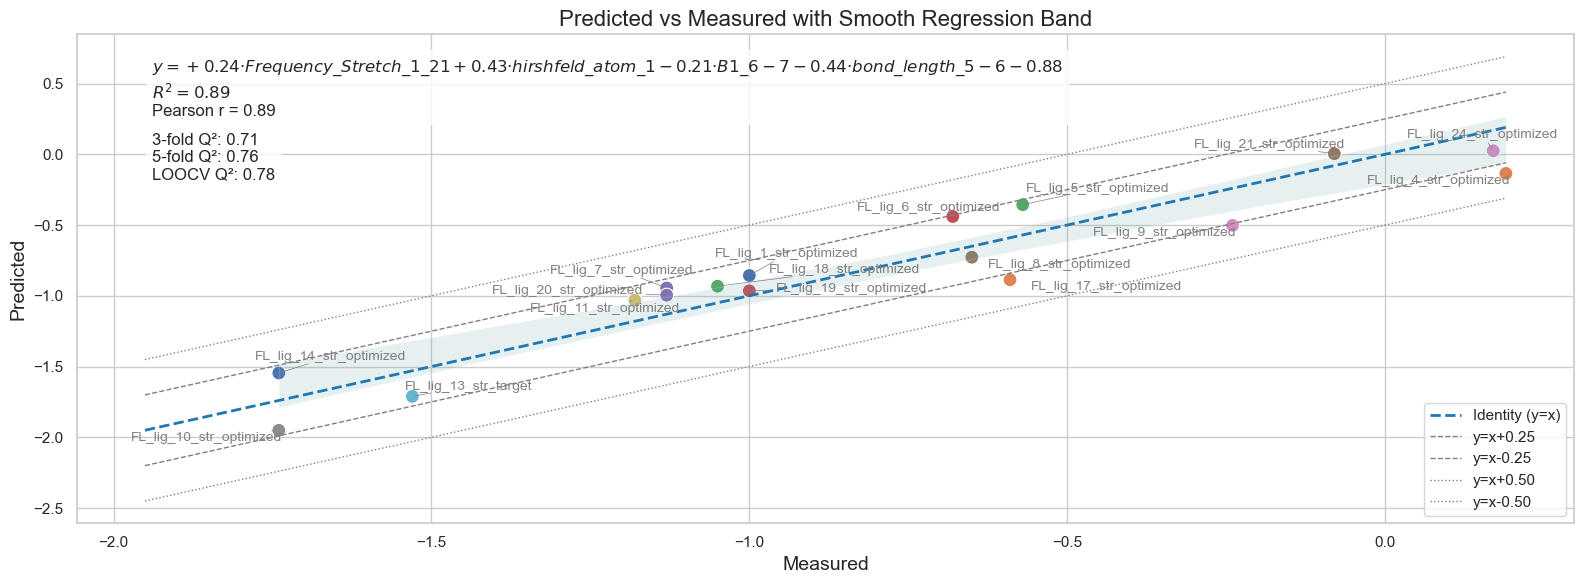

In [3]:
features_sterimol =['Frequency_Stretch_1_21','hirshfeld_atom_1','B1_6-7','bond_length_5-6']

plot.generate_and_display_q2_scatter_plot(Regression_model,features_sterimol)

In [1]:
sterimol_example = mols.molecules[0].get_sterimol([4,1])

NameError: name 'mols' is not defined